# Update 2021/01/06 

I make this copy to show that things have worked well. It can be used a reference. 


# Distribution of Coalescent times under differing population histories

This is a notebook to outline problems I am having. I will present this in self-contained way so that it is reproducible. I refer entirely to notation and equations as in the journal _"On the importance of being structured: instantaneouscoalescence rates and human evolution—lessons for ancestral population size inference?"_ by O Mazet, W Rodriguez, S Grusea, S Boitard, and L Chikhi.

## Setup

These are the dependencies and functions needed, can skip over.

In [33]:
# dependencies

import os
from datetime import datetime
import argparse
import numpy as np
import pdb
import math
import pandas as pd
from scipy.stats import entropy
import argparse
import matplotlib.pyplot as plt
import numpy as np
import msprime

# change plot size
plt.rcParams['figure.figsize'] = [12, 8]

In this notebook I record the observed sequence of tMRCAs along a genome, as returned by msprime. The following functions in the below code block are the mechanisms to do that.

In [23]:
def get_coal_data(sim,bin_length):
    tmrca_data = [] # first tuple is index, second tuple is sequence interval, third tuple is tMRCA
    ind = 0 #index for binning
    for tree in sim.trees():
        tmrca_data.append((tree.index,tree.interval[1],tree.time(tree.parent(0))))
        ind = math.floor(tree.interval[1]/bin_length)
    return tmrca_data

def round_bin_coal_data(seq_length,tmrca_data,bin_length):
    coal_times = np.zeros(shape=(int(seq_length/bin_length))) # create empty array which will store the binned coalescent times
    ind = 0 #index for binning
    for i in range(0,len(tmrca_data)):
        coal_times[ind:math.floor(tmrca_data[i][1]/bin_length)] = tmrca_data[i][2]
        ind = math.floor(tmrca_data[i][1]/bin_length)
    return coal_times

def round_coal_times(coal_times,T_scaled_np,N_T):
    # coal_times are the (exact) coalescent times along a sequence, as given by ms prime
    # T_scaled_np are the scaled time intervals (in a np aray)
    # N_T is the number of hidden states
    coal_times_intervals = [] 
    for i in range(0,len(coal_times)):
        diff = coal_times[i] - T_scaled_np
        diff_pos = diff[diff >0]
        where = np.argmin(diff_pos) # find closest interval
        if where == N_T: #TODO find a better fix for this. Have extended T to include upper interval
            where = where - 1
        coal_times_intervals.append(where) 
    return coal_times_intervals

def num_occcurences(array,time_intervals):
    counts = np.zeros(shape=len(time_intervals))
    for i in range(len(array)):
        counts[array[i]] += 1
    return counts

def get_counts_freq(sim,time_intervals,bin_length):
    # this function returns the observed pdf of T2 (f_T2(t))

    # get true coalescent data
    tmrca_data = get_coal_data(sim, bin_length) 

    # round this data into segments of size args.bin_length 
    coal_times = round_bin_coal_data(sim.sequence_length,tmrca_data, bin_length) # partition coalescent data into bins  


    # round coalescence time into interval
    coal_times_intervals = np.array(round_coal_times(coal_times,time_intervals,N_T=len(time_intervals))) # round binned coalescent times into their respected interval

    # count number of occurunces in each interval
    counts = num_occcurences(coal_times_intervals,time_intervals)

    # get frequency of these (divide by sum). This is the pdf (=f_T2(t))
    counts_freq = counts / counts.sum()
    return counts_freq

## Population size changes over time

I first demonstrate that things work for a population that experiences size changes over time. 

I will create a history that doubles in size at time T_1 then returns to normal size at time T_2.

In [24]:
# define history
def psc(T_1,T_2,seq_length):
    N_0 = 1e+04 # diploid population size
    population_configurations = [
        msprime.PopulationConfiguration(sample_size=2, initial_size=N_0, growth_rate=0),
    ]
    demographic_events = [
        msprime.PopulationParametersChange(time=T_1, initial_size=N_0*2),
        msprime.PopulationParametersChange(time=T_2, initial_size=N_0)
    ]
    # Use the demography debugger to print out the demographic history
    # that we have just described.
    dd = msprime.DemographyDebugger(
        population_configurations=population_configurations,demographic_events=demographic_events)
    print('Demographic history:\n')
    dd.print_history()
    sim = msprime.simulate(population_configurations=population_configurations,
                           demographic_events=demographic_events, length=seq_length, recombination_rate=2e-08,
                           mutation_rate=2e-08)
    return sim


In [11]:
# run simulation
seq_length = 150e+06
T_1 = 20000
T_2 = 50000

print("Running simulation")
sim1 = psc(T_1,T_2,seq_length)
print("Simulation finished")

Running simulation
Demographic history:

Model =  hudson(reference_size=1)
Epoch: 0 -- 20000.0 generations
     start     end      growth_rate |     0    
   -------- --------       -------- | -------- 
0 |  1e+04    1e+04               0 |     0    

Events @ generation 20000.0
   - Population parameter change for -1: initial_size -> 20000.0 
Epoch: 20000.0 -- 50000.0 generations
     start     end      growth_rate |     0    
   -------- --------       -------- | -------- 
0 |  2e+04    2e+04               0 |     0    

Events @ generation 50000.0
   - Population parameter change for -1: initial_size -> 10000.0 
Epoch: 50000.0 -- inf generations
     start     end      growth_rate |     0    
   -------- --------       -------- | -------- 
0 |  1e+04    1e+04               0 |     0    

Simulation finished


To measure the observed distribution, we must count number of coalescences in particular time intervals. 
When we consider the analytical expectation, we must scale these by some number (a linear function of bin_length, sequence_length, number and spacing of time intervals and something else that I can't figure out) which i can estimate hueristically, to match the observations

In [177]:
min_time = 0
max_time = 3e+05
spacing = 1000
bin_length = 100
time_intervals = np.arange(min_time,max_time,spacing)

# scaling
scaling = 250*len(time_intervals)*(bin_length/seq_length)

Now record the observations, using the functions we defined earlier.

In [ ]:
f_obs1 = get_counts_freq(sim1,time_intervals,bin_length) # empirical pdf for non panmictic history, with constant structure and constant size

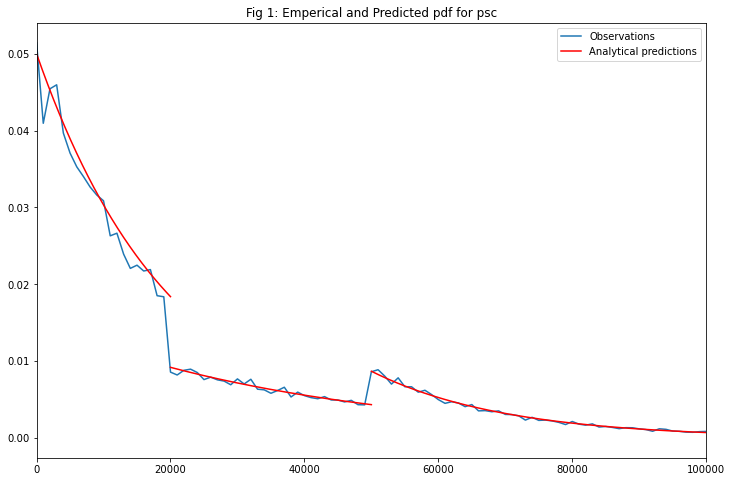

In [178]:
# standard pdf
def f1(x,N):
    x = x/(2*N)
    f = np.exp(-x)
    return f*scaling

def f2(x,T_1,N):
    x = x/(2*N)
    T_1 = T_1/(2*N)
    bigger_T_1 = np.exp(-T_1)
    f = bigger_T_1 * 0.5*np.exp(-(x-T_1)/2)
    return f*scaling

def f3(x,T_1,T_2,N):
    x = x/(2*N)
    T_1 = T_1/(2*N)
    T_2 = T_2/(2*N)
    bigger_T_2 = np.exp(-T_1)*(1 - (1-np.exp(-(T_2-T_1)/2)))
    f = bigger_T_2 * np.exp(-(x-T_2))
    return f*scaling
    
t1 = np.arange(0,T_1,1) # first epoch
t2 = np.arange(T_1,T_2,1) # second epoch
t3 = np.arange(T_2,max_time,1) # third epoch


N = 10000 # diploid population size

line_obs = plt.plot(time_intervals,f_obs1,label="Observations")
line_f1 = plt.plot(t1,f1(t1,N),label="Analytical predictions",color="red")
line_f2 = plt.plot(t2,f2(t2,T_1,N),color="red")
line_f3 = plt.plot(t3,f3(t3,T_1,T_2,N),color="red")
plt.legend()
plt.xlim(0,100000)
plt.title('Fig 1: Emperical and Predicted pdf for psc')
plt.show()

As one can see, the predictions fit the observations well.

From here, it is easy to calculate F (the CDF) and the IICR.

## Population experiencing structure

Now I will try to fit the pdf for a history that experienced structure.

### Same deme

I will follow the n-island model, with 2 islands and sampling initially from the same deme. I use the notation as given in the manuscript mentioned above. 


In [93]:
def structure_samedeme(mig_rate,N,T_1,T_2,seq_length):
    N_A0 = N
    N_B0 =  N
    m = mig_rate
    
    population_configurations = [
        msprime.PopulationConfiguration(
            sample_size=2, initial_size=N_A0, growth_rate=0),
        msprime.PopulationConfiguration(
            sample_size=0, initial_size=N_B0, growth_rate=0)
    ]
    migration_matrix = [[0,0],[0,0]]
    demographic_events = [
        msprime.MigrationRateChange(time = T_1,rate = m, matrix_index=(0,1)),
        msprime.MigrationRateChange(time = T_1,rate = m, matrix_index=(1,0)),
        msprime.MigrationRateChange(time = T_2,rate = 0, matrix_index=(0,1)),
        msprime.MigrationRateChange(time = T_2,rate = 0, matrix_index=(1,0)),        
        msprime.MassMigration(time=T_2, source =1, destination =0, proportion = 1)
    ]
    dd = msprime.DemographyDebugger(
        population_configurations=population_configurations,migration_matrix=migration_matrix,
        demographic_events=demographic_events)

    print('Demographic history:\n')
    dd.print_history()
    sim = msprime.simulate(population_configurations=population_configurations,
                           demographic_events=demographic_events, length=seq_length, recombination_rate=2e-08,mutation_rate=2e-08)
    return sim


In [98]:
# run simulation
seq_length = 150e+06
T_1 = 0
T_2 = 80000
mig_rate = 5e-05
N = 10000

print("Running simulation")
sim2 = structure_samedeme(mig_rate,N,T_1,T_2,seq_length)
print("Simulation finished")

Running simulation
Demographic history:

Model =  hudson(reference_size=1)
Events @ generation 0
   - Migration rate change for (0, 1) to 5e-05
   - Migration rate change for (1, 0) to 5e-05
Epoch: 0 -- 0.0 generations
     start     end      growth_rate |     0        1    
   -------- --------       -------- | -------- -------- 
0 |  1e+04    1e+04               0 |     0        0    
1 |  1e+04    1e+04               0 |     0        0    

Epoch: 0.0 -- 80000.0 generations
     start     end      growth_rate |     0        1    
   -------- --------       -------- | -------- -------- 
0 |  1e+04    1e+04               0 |     0      5e-05  
1 |  1e+04    1e+04               0 |   5e-05      0    

Events @ generation 80000.0
   - Migration rate change for (0, 1) to 0
   - Migration rate change for (1, 0) to 0
   - Mass migration: Lineages moved with probability 1 backwards in time with source 1 & dest 0
                     (equivalent to migration from 0 to 1 forwards in time)
Epo

Record observations

In [ ]:
f_obs2 = get_counts_freq(sim2,time_intervals,bin_length) # empirical pdf for non panmictic history, with constant structure and constant size

M, gamma, theta, discriminant, alpha, beta, a, c are [2.0, 2.0, 0.0008, 17.0, 4.561552812808831, 0.4384471871911697, 0.6212678125181664, -0.4850712500726658]


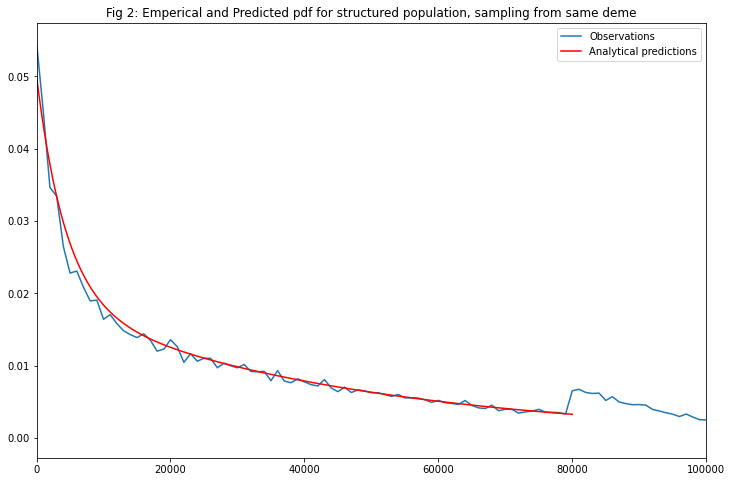

In [183]:
# set up parameters

N = 20000 # haploid genomes 

# n is number of demes
n = 2

# m is migration rate
m = mig_rate

# n is number of islands
n = 2

M = 2*N*m

gamma = M/(n-1)

mu = 2e-08

theta = 2 * N * mu 

discriminant = (1+n*gamma)**2 - 4*gamma

alpha = 0.5*(1 + n*gamma + np.sqrt(discriminant))

beta = 0.5*(1 + n*gamma - np.sqrt(discriminant))

a = (gamma-alpha)/(beta-alpha)

c = gamma/(beta-alpha)

print('M, gamma, theta, discriminant, alpha, beta, a, c are {}'.format([M, gamma, theta, discriminant, alpha, beta, a, c]))

# equation 10
def f_samedeme(x,a,alpha,beta,N,n):
    # if j is generations, do we scale with j/(number of haploid genomes) or ((num of demes)*j)/(number of haploid genomes)
    # i.e. x = j/N or x = (n*j)/N 
    # I tried both, neither fits data
    x = (x)/(N) 
    f = a*np.exp(-alpha*x) + (1-a)*np.exp(-beta*x)
    return f*scaling

t1 = np.arange(0,T_2,1) # first epoch
t2 = np.arange(T_2,max_time,1) # first epoch


line_obs = plt.plot(time_intervals,f_obs2,label="Observations")
line_f1 = plt.plot(t1,f_samedeme(t1,a,alpha,beta,N,n),label="Analytical predictions",color="red")
# line_f2 = plt.plot(t2,f2(t2,T_1,N),color="red")
# line_f3 = plt.plot(t3,f3(t3,T_1,T_2,N),color="red")
plt.legend()
plt.xlim(0,100000)
plt.title('Fig 2: Emperical and Predicted pdf for structured population, sampling from same deme')
plt.show()

Isn't quite a good fit.

### Different deme

Now i try with sampling from a different deme

In [138]:
def structure_diffdeme(mig_rate,N,T_1,T_2,seq_length):
    N_A0 = N
    N_B0 =  N
    m = mig_rate
    
    population_configurations = [
        msprime.PopulationConfiguration(
            sample_size=1, initial_size=N_A0, growth_rate=0),
        msprime.PopulationConfiguration(
            sample_size=1, initial_size=N_B0, growth_rate=0)
    ]
    migration_matrix = [[0,0],[0,0]]
    demographic_events = [
        msprime.MigrationRateChange(time = T_1,rate = m, matrix_index=(0,1)),
        msprime.MigrationRateChange(time = T_1,rate = m, matrix_index=(1,0)),
        msprime.MigrationRateChange(time = T_2,rate = 0, matrix_index=(0,1)),
        msprime.MigrationRateChange(time = T_2,rate = 0, matrix_index=(1,0)),        
        msprime.MassMigration(time=T_2, source =1, destination =0, proportion = 1)
    ]
    dd = msprime.DemographyDebugger(
        population_configurations=population_configurations,migration_matrix=migration_matrix,
        demographic_events=demographic_events)

    print('Demographic history:\n')
    dd.print_history()
    sim = msprime.simulate(population_configurations=population_configurations,
                           demographic_events=demographic_events, length=seq_length, recombination_rate=2e-08,mutation_rate=2e-08)
    return sim

In [139]:
# run simulation
seq_length = 150e+06
T_1 = 0
T_2 = 80000
mig_rate = 5e-05
N = 10000

print("Running simulation")
sim3 = structure_diffdeme(mig_rate,N,T_1,T_2,seq_length)
print("Simulation finished")

Running simulation
Demographic history:

Model =  hudson(reference_size=1)
Events @ generation 0
   - Migration rate change for (0, 1) to 5e-05
   - Migration rate change for (1, 0) to 5e-05
Epoch: 0 -- 0.0 generations
     start     end      growth_rate |     0        1    
   -------- --------       -------- | -------- -------- 
0 |  1e+04    1e+04               0 |     0        0    
1 |  1e+04    1e+04               0 |     0        0    

Epoch: 0.0 -- 80000.0 generations
     start     end      growth_rate |     0        1    
   -------- --------       -------- | -------- -------- 
0 |  1e+04    1e+04               0 |     0      5e-05  
1 |  1e+04    1e+04               0 |   5e-05      0    

Events @ generation 80000.0
   - Migration rate change for (0, 1) to 0
   - Migration rate change for (1, 0) to 0
   - Mass migration: Lineages moved with probability 1 backwards in time with source 1 & dest 0
                     (equivalent to migration from 0 to 1 forwards in time)
Epo

In [ ]:
f_obs3 = get_counts_freq(sim3,time_intervals,bin_length) # empirical pdf for non panmictic history, with constant structure and constant size

M, gamma, theta, discriminant, alpha, beta, a, c are [2.0, 2.0, 0.0008, 17.0, 4.561552812808831, 0.4384471871911697, 0.6212678125181664, -0.4850712500726658]


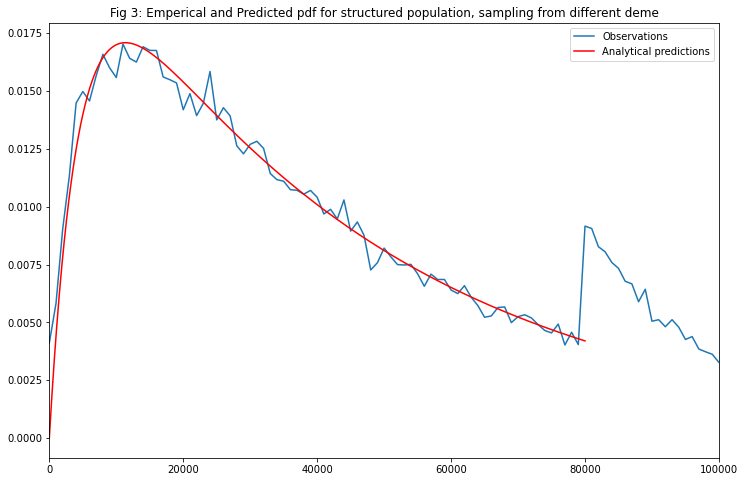

In [186]:
# set up parameters

# number of haploid genomes
N = 20000

# n is number of demes
n = 2

# N is population size of deme

# m is migration rate
m = mig_rate

# n is number of islands
n = 2

M = 2*N*m

gamma = M/(n-1)

mu = 2e-08

theta = 2 * N * mu 

discriminant = (1+n*gamma)**2 - 4*gamma

alpha = 0.5*(1 + n*gamma + np.sqrt(discriminant))

beta = 0.5*(1 + n*gamma - np.sqrt(discriminant))

a = (gamma-alpha)/(beta-alpha)

c = gamma/(beta-alpha)

print('M, gamma, theta, discriminant, alpha, beta, a, c are {}'.format([M, gamma, theta, discriminant, alpha, beta, a, c]))

# equation 11
def f_diffdeme(x,c,alpha,beta,N,n):
    # do we scaled with j/N or (n*j)/N
    x = (x)/N 
    f = c*np.exp(-alpha*x) - c*np.exp(-beta*x)
    return f*scaling

t1 = np.arange(0,T_2,1) # first epoch
t2 = np.arange(T_2,max_time,1) # first epoch

line_obs = plt.plot(time_intervals,f_obs3,label="Observations")
line_f1 = plt.plot(t1,f_diffdeme(t1,c,alpha,beta,N,n),label="Analytical predictions",color="red")
# line_f2 = plt.plot(t2,f2(t2,T_1,N),color="red")
# line_f3 = plt.plot(t3,f3(t3,T_1,T_2,N),color="red")
plt.legend()
plt.xlim(0,100000)
plt.title('Fig 3: Emperical and Predicted pdf for structured population, sampling from different deme')
plt.show()

## Conclusion

It seems that things are working. That is good.

In [187]:
print('hello Mayumi!')

hello Mayumi!
